# Abschlussprojekt - Diskriminierung in Machine Learning Modellen

Dieses Notebook analysiert den `adult.csv`-Datensatz unter besonderer Berücksichtigung von Fairness-Aspekten in Machine-Learning-Modellen.

### Zielsetzung:
- **Explorative Datenanalyse (EDA):** Siehe EDA-Notebook
- **Machine Learning Modelle:** Vergleich mehrerer Modelle hinsichtlich ihrer Vorhersagegenauigkeit und Fairness.
- **Fairness-Analyse:** Berechnung von Fairness-Metriken zur Bewertung der Diskriminierung.

In [25]:
# Import notwendiger Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os

from data_cleaning import fill_missing_values, rename_columns
from data_science_skript import preprocess_data, generate_plots, train_and_predict, evaluate_model, evaluate_discrimination

from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
import time

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler


from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference, demographic_parity_ratio
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.reductions import EqualizedOdds

# Sytle für Plots
plt.style.use("dark_background")
colors = ["silver", "teal"]

In [2]:
# Laden und aufbereiten der Daten
df = pd.read_csv(r"C:\Users\kimko\PortfolioProjekt\adult.csv", na_values=["?"]) 
df = fill_missing_values(df) 
df = rename_columns(df)

### Knappe Explorative Datenanalyse (EDA) hinsichtlich der Einkommensverteilung nach Geschlecht und Ethnie

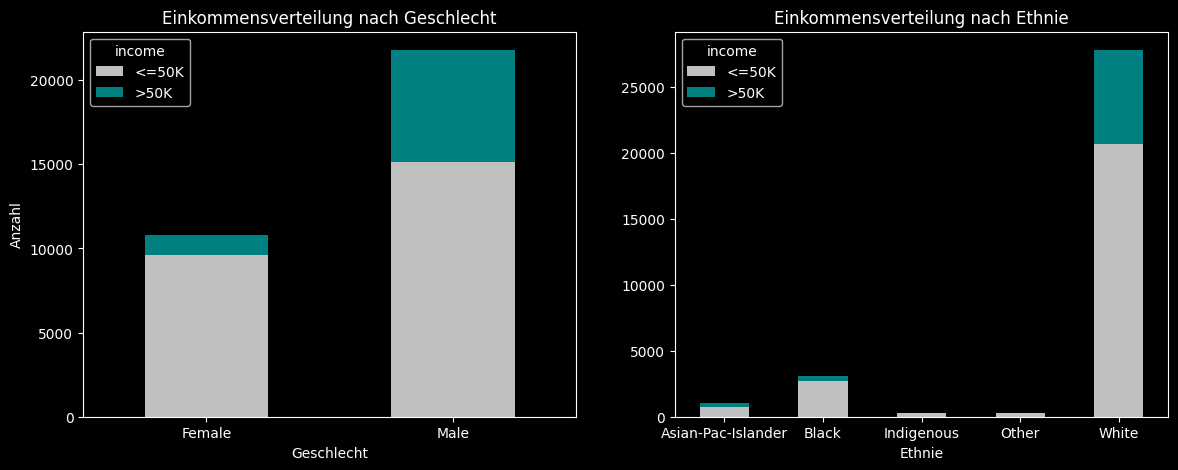

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Einkommensverteilung nach Geschlecht
df.groupby(["sex", "income"]).size().unstack().plot(kind="bar", stacked=True, color=colors, ax=ax[0])
ax[0].set_title("Einkommensverteilung nach Geschlecht")
ax[0].set_xlabel("Geschlecht")
ax[0].set_ylabel("Anzahl")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)

# Einkommensverteilung nach Ethnie
df.groupby(["race", "income"]).size().unstack().plot(kind="bar", stacked=True, color=colors, ax=ax[1])
ax[1].set_title("Einkommensverteilung nach Ethnie")
ax[1].set_xlabel("Ethnie")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

plt.show()

In [4]:
# Variablen umwandeln
df = preprocess_data(df)

File 'files\heatmap.png' already exists. Loading...


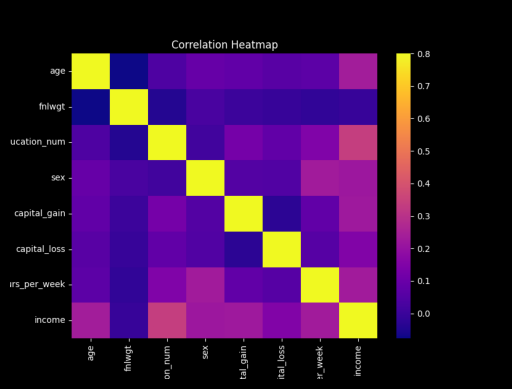

File 'files\pairplot.png' already exists. Loading...


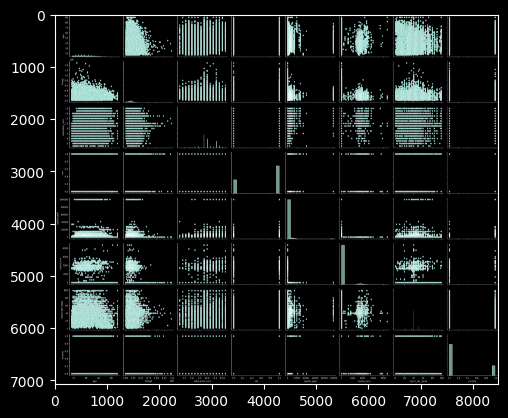

In [5]:
generate_plots(df) 

### Machine Learning Modelle

- Logistische Regression
- Decision Tree
- Random Forest

#### Vorbereitung

In [6]:
# Train-Test-Split
pickle_train_test = "files/train_test_split.pkl"

if os.path.exists(pickle_train_test):
    print("Lade bereits gespeicherte Trainings- und Testdaten...")
    with open(pickle_train_test, "rb") as file:
        features_train, features_test, target_train, target_test = pickle.load(file)
else:
    print("Erstelle neue Trainings- und Testdaten...")
    
    # Daten splitten
    target = df["income"]
    features = df.drop(columns=["income"])

    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.2, stratify=target, random_state=42
    )

    # Daten speichern
    with open(pickle_train_test, "wb") as file:
        pickle.dump((features_train, features_test, target_train, target_test), file)

    print("Daten wurden gespeichert!")

Lade bereits gespeicherte Trainings- und Testdaten...


In [7]:
print("Trainingsdaten:\n",features_train.shape)
print("\nTestdaten:\n",features_test.shape)

Trainingsdaten:
 (26048, 14)

Testdaten:
 (6513, 14)


In [8]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex                int64
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income             int64
dtype: object

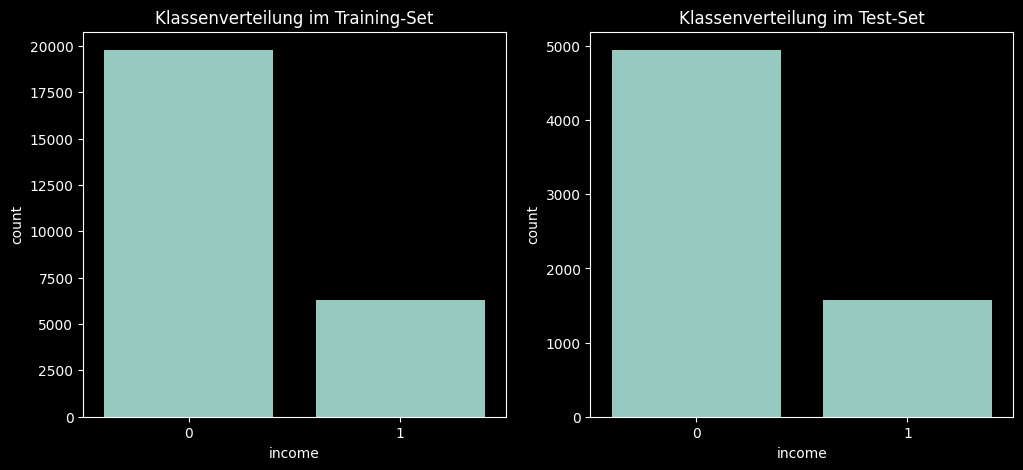

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=target_train, ax=ax[0])
ax[0].set_title("Klassenverteilung im Training-Set")

sns.countplot(x=target_test, ax=ax[1])
ax[1].set_title("Klassenverteilung im Test-Set")

plt.show()


In [10]:
train_crosstab_income = pd.crosstab(index=target_train, columns = "count", normalize = "columns")
test_crosstab_income = pd.crosstab(index=target_test, columns = "count", normalize = "columns")
display(train_crosstab_income)
display(test_crosstab_income)

col_0,count
income,
0,0.759175
1,0.240825


col_0,count
income,
0,0.759251
1,0.240749


#### Logistische Regression

In [11]:
# Vorbereitung
num_cols = features_train.select_dtypes(include=["int64"]).columns
cat_cols = features_train.select_dtypes(include=["object"]).columns 

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Baselinemodell Logistische Regression
pipeline_log_base = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(class_weight="balanced", random_state = 42))
     ])

target_pred_log = train_and_predict(pipeline_log_base, features_train, target_train, features_test, target_test)
metrics_log = evaluate_model(target_test, target_pred_log)
metrics_log

{'Accuracy': 0.8079226163058498,
 'Precision': 0.8500979570481941,
 'Recall': 0.8079226163058498,
 'F1 Score': 0.8184998090112877,
 'ROC-AUC': 0.8179784388477334}

#### Decision Tree

In [12]:
# Decision Tree
pipeline_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(class_weight="balanced", random_state = 42))
     ])

target_pred_dt = train_and_predict(pipeline_dt, features_train, target_train, features_test, target_test)
metrics_dt = evaluate_model(target_test, target_pred_dt)
metrics_dt

{'Accuracy': 0.8142177184093352,
 'Precision': 0.8133388033345845,
 'Recall': 0.8142177184093352,
 'F1 Score': 0.8137676295784005,
 'ROC-AUC': 0.7435107612306804}

#### Random Forest

In [13]:
# Random Forest
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=42))
])

target_pred_rf = train_and_predict(pipeline_rf, features_train, target_train, features_test, target_test)
metrics_rf = evaluate_model(target_test, target_pred_rf)
metrics_rf

{'Accuracy': 0.8515277138031629,
 'Precision': 0.8453265817526976,
 'Recall': 0.8515277138031629,
 'F1 Score': 0.8465281088809512,
 'ROC-AUC': 0.7676455036008336}

#### Visualisierung

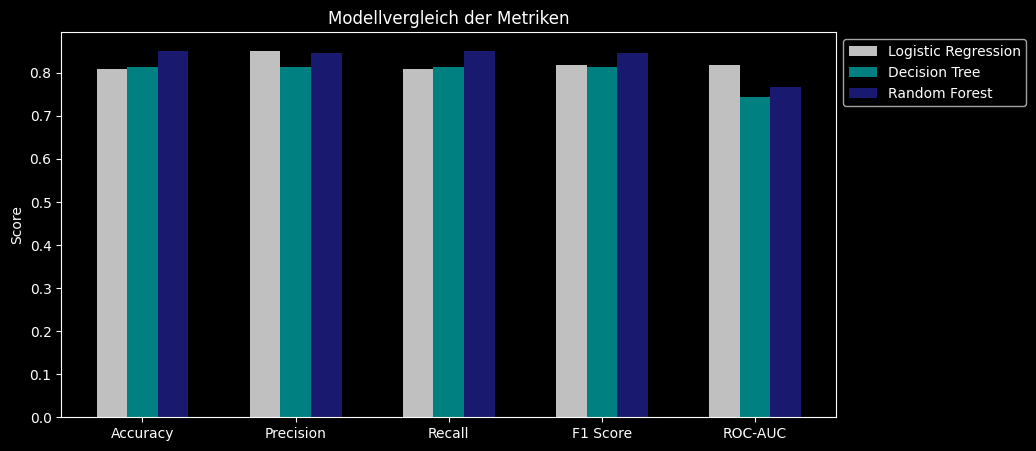

In [14]:
# Ergebnisse der drei Basismodelle
model_results = {
    "Logistic Regression": metrics_log,
    "Decision Tree": metrics_dt,
    "Random Forest": metrics_rf
}

# Extrahieren der Metriken
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
model_names = list(model_results.keys())

bar_width = 0.2
x = np.arange(len(metrics))
color_model= ["silver", "teal", "midnightblue"]

fig, ax = plt.subplots(figsize=(10, 5))

for i, (model, color) in enumerate(zip(model_names, color_model)):
    values = [model_results[model][metric] for metric in metrics]
    ax.bar(x + i * bar_width, values, width=bar_width, label=model, color=color)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_title("Modellvergleich der Metriken")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance Random Forest')

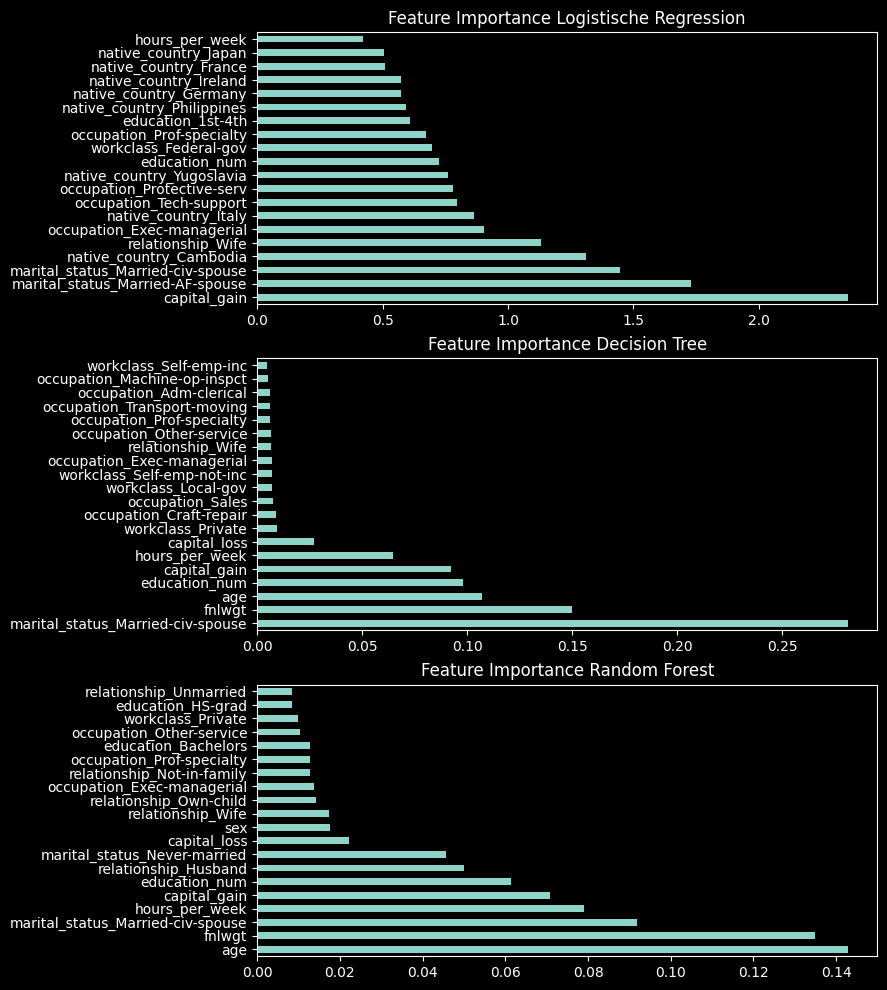

In [15]:
# Feature-Importance des Base-Line Modells
feature_names = list(num_cols) + list(pipeline_log_base.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols))
coefficients = pipeline_log_base.named_steps["model"].coef_[0]
feature_importance_log = pd.Series(data = pipeline_log_base.named_steps["model"].coef_[0],
                               index = feature_names).sort_values(ascending=False)


# Feature Importance für Baummodelle
feature_names = list(num_cols) + list(pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols))

# Für den DecisionTree
feature_importance_dt = pd.Series(data=pipeline_dt.named_steps["model"].feature_importances_,
                               index=feature_names).sort_values(ascending=False)

#Für den RandomForest
feature_importance_rf = pd.Series(data=pipeline_rf.named_steps["model"].feature_importances_,
                               index=feature_names).sort_values(ascending=False)


# Plot
fig, ax = plt.subplots(3, 1, figsize=(8, 12)) 
feature_importance_log.head(20).plot(kind='barh', ax = ax[0])
feature_importance_dt.head(20).plot(kind='barh', ax = ax[1])
feature_importance_rf.head(20).plot(kind='barh', ax = ax[2])

ax[0].set_title("Feature Importance Logistische Regression")
ax[1].set_title("Feature Importance Decision Tree")
ax[2].set_title("Feature Importance Random Forest")

### Random Forest optimieren

In [16]:

pickle_randomforest_baysian = "files/randomforest_baysian.pkl"

if os.path.exists(pickle_randomforest_baysian):
    print("Lade bereits gespeicherte RandomForestBaysian Ergebnisse...")
    with open(pickle_randomforest_baysian, "rb") as file:
        study = pickle.load(file)
else:
    print("Erstelle Random-Forest-Baysian Optimierung...")
    
    def objective(trial):
        """Optimization of the RandomForest Hyperparameter"""

        #Searchspace
        n_estimators = trial.suggest_int("n_estimators", 50, 250)
        max_depth = trial.suggest_int("max_depth", 3, 15)
        max_features = trial.suggest_categorical("max_features", ["log2", "sqrt"])
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=2)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

        #Model
        params = {
            "n_estimators": n_estimators,
            "max_features": max_features,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf
        }

        model_rf = RandomForestClassifier(class_weight="balanced", random_state=42, **params)

        num_cols = features_train.select_dtypes(include=["int64"]).columns
        cat_cols = features_train.select_dtypes(include=["object"]).columns 

        preprocessor = ColumnTransformer([
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        ])
        
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model_rf)
        ])

        score = cross_val_score(
            estimator=pipeline, 
            X=features_train, 
            y=target_train, 
            scoring="balanced_accuracy",
            cv=3,
            n_jobs=1
        ).mean()

        return score

    # create a study and setting a seed for reproduceability
    study = optuna.create_study(sampler=TPESampler(seed=42), direction='maximize')

    # perform hyperparameter tuning
    time_start = time.time()
    study.optimize(objective, n_trials=30)
    time_bayesian = time.time() - time_start

    # store result in a data frame 
    values_bayesian = [
        30, 
        study.best_trial.number, 
        study.best_trial.value, 
        time_bayesian
    ]

    results_bayesian = pd.DataFrame([values_bayesian], columns=[
        "Number of iterations", 
        "Iteration Number of Optimal Hyperparameters", 
        "Score", 
        "Time Elapsed (s)"
    ])

    # best hyperparameter
    print("\nBeste Hyperparameter für Random Forest:")
    print(study.best_trial.params)

    # show results
    print("\nOptimierungsergebnisse:")
    print(results_bayesian)

    # Daten speichern
    with open(pickle_randomforest_baysian, "wb") as file:
        pickle.dump(study, file)

    print("Daten wurden gespeichert!")



Lade bereits gespeicherte RandomForestBaysian Ergebnisse...


In [ ]:
# Anwendung der Hyperparameter

best_params = study.best_params

model_rf_ba = RandomForestClassifier(class_weight="balanced", random_state=42, **best_params)
pipeline_rf_ba = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_rf_ba)
])

target_pred_rf_ba = train_and_predict(pipeline_rf_ba, features_train, target_train, features_test, target_test)
metrics_rf_ba = evaluate_model(target_test, target_pred_rf_ba)


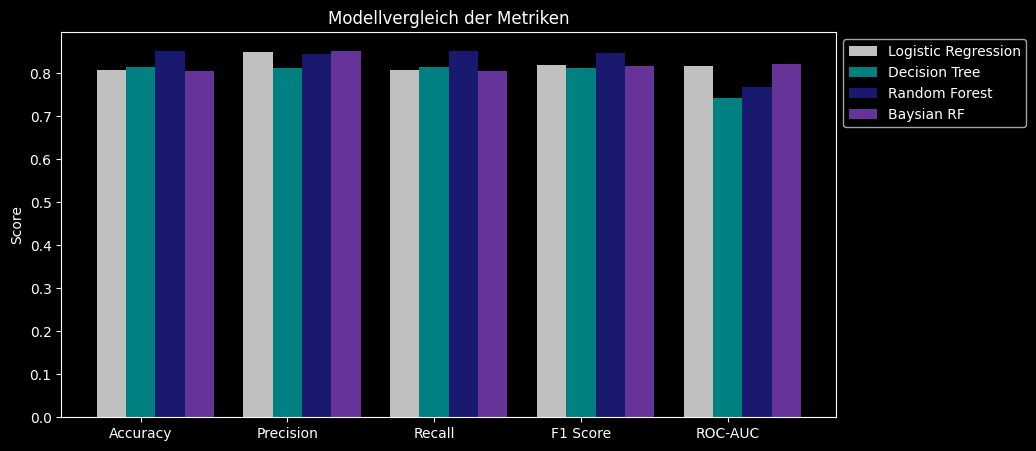

In [ ]:
# Ergebnisse der drei Basismodelle
model_results = {
    "Logistic Regression": metrics_log,
    "Decision Tree": metrics_dt,
    "Random Forest": metrics_rf,
    "Baysian RF": metrics_rf_ba
}

# Extrahieren der Metriken
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
model_names = list(model_results.keys())

bar_width = 0.2
x = np.arange(len(metrics))
color_model= ["silver", "teal", "midnightblue", "rebeccapurple"]

fig, ax = plt.subplots(figsize=(10, 5))

for i, (model, color) in enumerate(zip(model_names, color_model)):
    values = [model_results[model][metric] for metric in metrics]
    ax.bar(x + i * bar_width, values, width=bar_width, label=model, color=color)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_title("Modellvergleich der Metriken")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

#### Fairness-Metriken

ROC-AUC nach Gruppen (1)
Diese Metrik zeigt, wie gut ein Modell zwischen verschiedenen Klassen für verschiedene demografische Gruppen unterscheiden kann, wobei Unterschiede auf mögliche Fairnessprobleme hindeuten können.

EOD (Equal Opportunity Difference) (0)
Misst die Differenz zwischen den True-Positive-Raten verschiedener demografischer Gruppen und zeigt an, ob ein Modell gleiche Chancen für positive Vorhersagen bei tatsächlich positiven Fällen bietet.

DPR (Disparate Positive Rate)(1)
Vergleicht die Verhältnisse positiver Vorhersagen zwischen verschiedenen demografischen Gruppen und quantifiziert, ob das Modell für bestimmte Gruppen häufiger positive Ergebnisse vorhersagt.

DPD (Demographic Parity Difference)(0) Misst den absoluten Unterschied zwischen den Raten positiver Vorhersagen verschiedener demografischer Gruppen und zeigt, ob das Modell statistische Parität unabhängig von der tatsächlichen Verteilung erreicht.


In [20]:
fair_metric_log = evaluate_discrimination(target_test, target_pred_log, features_test)
fair_metric_dt = evaluate_discrimination(target_test, target_pred_dt, features_test)
fair_metric_rf = evaluate_discrimination(target_test, target_pred_rf, features_test)
fair_metric_rf_ba = evaluate_discrimination(target_test, target_pred_rf_ba, features_test)

In [21]:
model_names = ["Logistische Regression", "Decision Tree", "Random Forest", "Baysian RF"]
metrics = [fair_metric_log, fair_metric_dt, fair_metric_rf, fair_metric_rf_ba]
# Erstellen eines übersichtlichen DataFrames
results = pd.DataFrame()
results['Modell'] = model_names

# ROC-AUC Werte hinzufügen
for group in ['male', 'female', 'white', 'non_white']:
    results[f'ROC-AUC ({group})'] = [round(float(model['roc_auc'][group]), 3) for model in metrics]

# Andere Metriken hinzufügen
for metric, name in zip(['eod', 'dpr', 'dpd'], ['EOD', 'DPR', 'DPD']):
    for group in ['sex', 'race']:
        results[f'{name} ({group})'] = [round(float(model[metric][group]), 3) for model in metrics]

# Anzeigen des DataFrames
display(results)

,Modell,ROC-AUC (male),ROC-AUC (female),ROC-AUC (white),ROC-AUC (non_white),EOD (sex),EOD (race),DPR (sex),DPR (race),DPD (sex),DPD (race)
0,Logistische Regression,0.782,0.847,0.815,0.816,0.219,0.275,0.314,0.302,0.315,0.263
1,Decision Tree,0.727,0.752,0.743,0.735,0.106,0.611,0.370,0.548,0.189,0.113
2,Random Forest,0.758,0.760,0.769,0.743,0.079,0.490,0.309,0.320,0.179,0.145
3,Baysian RF,0.776,0.846,0.811,0.841,0.263,0.286,0.272,0.347,0.355,0.256


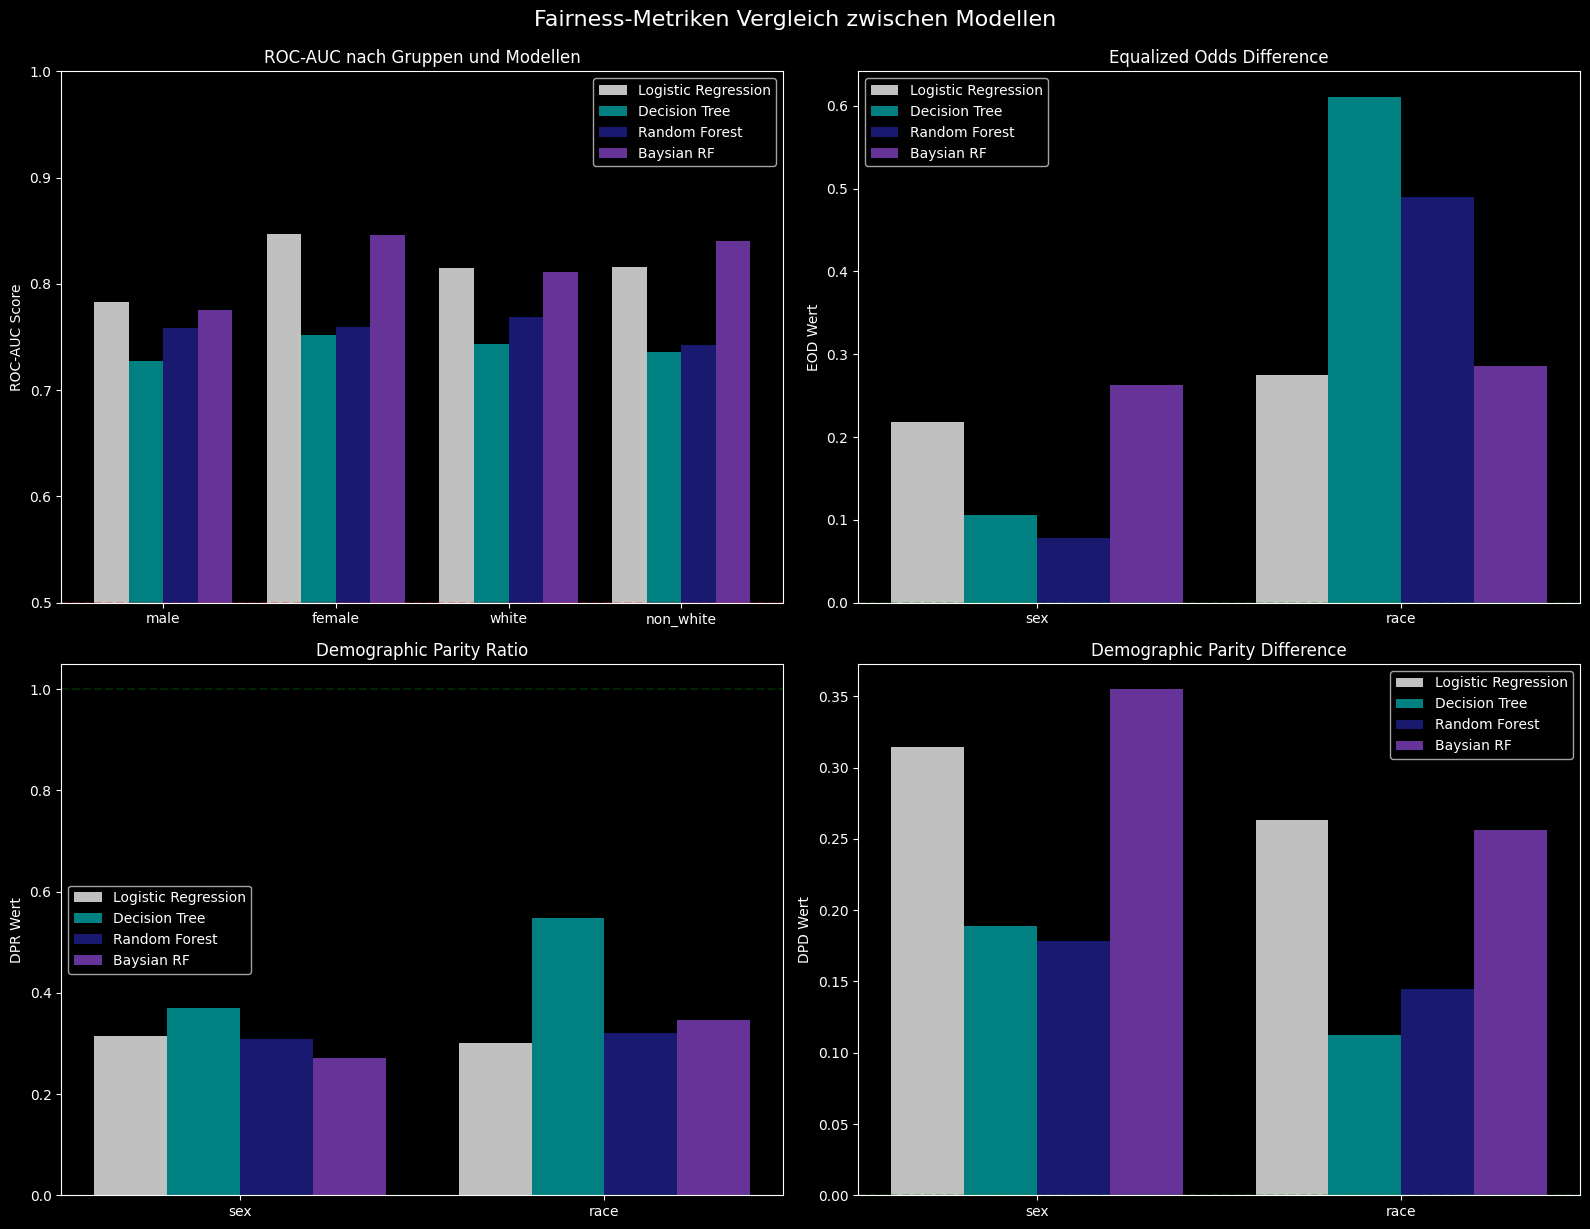

In [22]:

# Dictionary mit allen Modellen erstellen
models = {
    'Logistic Regression': fair_metric_log,
    'Decision Tree': fair_metric_dt,
    'Random Forest': fair_metric_rf,
    'Baysian RF': fair_metric_rf_ba
}

# Figure mit 2x2 Subplots erstellen
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Farbpalette für die Modelle
colors = ["silver", "teal", "midnightblue", "rebeccapurple"]

# 1. ROC-AUC Vergleich (oben links)
ax = axs[0, 0]
roc_metrics = ["male", "female", "white", "non_white"]
x = np.arange(len(roc_metrics))
width = 0.2 

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["roc_auc"][metric] for metric in roc_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('ROC-AUC Score')
ax.set_title('ROC-AUC nach Gruppen und Modellen')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(roc_metrics)
ax.set_ylim(0.5, 1.0)
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
ax.legend()

# 2. Equalized Odds Difference (oben rechts)
ax = axs[0, 1]
eod_metrics = ["sex", "race"]
x = np.arange(len(eod_metrics))

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["eod"][metric] for metric in eod_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('EOD Wert')
ax.set_title('Equalized Odds Difference')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(eod_metrics)
ax.axhline(y=0, color='g', linestyle='--', alpha=0.3)
ax.legend()

# 3. Demographic Parity Ratio (unten links)
ax = axs[1, 0]
dpr_metrics = ["sex", "race"]
x = np.arange(len(dpr_metrics))

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["dpr"][metric] for metric in dpr_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('DPR Wert')
ax.set_title('Demographic Parity Ratio')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(dpr_metrics)
ax.axhline(y=1, color='g', linestyle='--', alpha=0.3)
ax.legend()

# 4. Demographic Parity Difference (unten rechts)
ax = axs[1, 1]
dpd_metrics = ["sex", "race"]
x = np.arange(len(dpd_metrics))

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["dpd"][metric] for metric in dpd_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('DPD Wert')
ax.set_title('Demographic Parity Difference')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(dpd_metrics)
ax.axhline(y=0, color='g', linestyle='--', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.suptitle('Fairness-Metriken Vergleich zwischen Modellen', fontsize=16, y=1.02)
plt.savefig(r'files\fairness_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

##### DPR als eigenständige Visualisierung

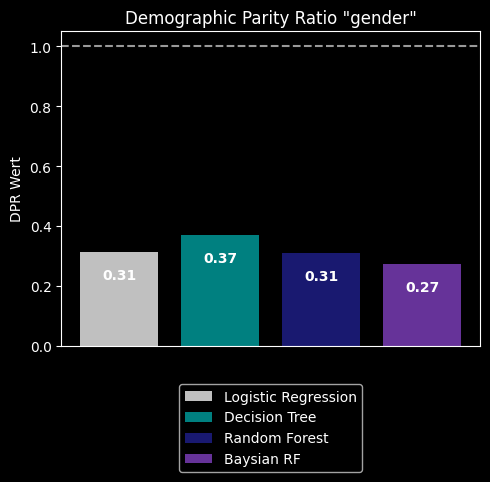

In [78]:
# Dictionary mit allen Modellen erstellen
models = {
    'Logistic Regression': fair_metric_log,
    'Decision Tree': fair_metric_dt,
    'Random Forest': fair_metric_rf,
    'Baysian RF': fair_metric_rf_ba
}

# Figure mit 2x2 Subplots erstellen
fig, ax = plt.subplots( figsize=(5, 5))

# Farbpalette für die Modelle
colors = ["silver", "teal", "midnightblue", "rebeccapurple"]

# Demographic Parity Ratio 
dpr_metrics = ["sex"]
x = np.arange(len(dpr_metrics))
width = 0.2
for i, (model_name, fairness_metrics) in enumerate(models.items()):
    value = fairness_metrics["dpr"]["sex"]
    ax.bar(x + i * width * 1.3, value, width, label=model_name, color=colors[i])

    ax.text(
        x=i * width * 1.3,  # X-Position (auf die Balken zentrieren)
        y=value - 0.1,  # Y-Position (leicht über dem Balken)
        s=f"{value:.2f}",  # Zahlenwert mit 2 Dezimalstellen
        ha='center',  # Zentriert ausrichten
        va='bottom',  # Am unteren Rand des Textes ausrichten
        fontsize=10,  # Schriftgröße anpassen
        color="white",  # Kontrast anpassen
        fontweight="bold"
    )
    
ax.set_ylabel('DPR Wert')
ax.set_title('Demographic Parity Ratio "gender"')
ax.set_xticks([])
ax.axhline(y=1, color='silver', linestyle='--', alpha=0.8)
ax.legend(loc="upper center",bbox_to_anchor=(0.5, -0.1), fontsize=10)



plt.tight_layout()
#plt.suptitle('Fairness-Metriken Vergleich zwischen Modellen', fontsize=16, y=1.02)
plt.savefig(r'files\fairness_model_comparison_DPR.svg', dpi=300, bbox_inches='tight')
plt.show()

### Bewertung dieser Modelle

Fairness-Beurteilung:
- Random Forest hat die höchste Disparitäten bei EOD und hohe DPR-Werte
- Logistische Regression zeigt besser Metriken
- Baysian RF bietet beste Fairness insgesamt

Präzision
- bisher RandomForest

Bester Mittelweg:
- Randomforest
    Bietet den besten Kompromiss zwischen Leistung und Fairness

#### Fairness Constraint
- In-Processing
- Post-Processing

In [23]:
# FairnessConstraints
constraint = DemographicParity()  # Alternativ: EqualizedOdds() -> würde noch länger laufen
fair_model_rf = ExponentiatedGradient(RandomForestClassifier(n_estimators=100, random_state=42), constraints=constraint)

# Preprocessor
X_train_processed = preprocessor.fit_transform(features_train)
X_train_processed = X_train_processed.toarray()

X_test_processed = preprocessor.transform(features_test)
X_test_processed = X_test_processed.toarray()

# Trainiere das Modell
fair_model_rf.fit(X_train_processed, target_train, sensitive_features=features_train[["sex", "race"]])

# Vorhersagen
target_pred_fair_rf = fair_model_rf.predict(X_test_processed)

In [ ]:
# FairnessConstraints
constraint = EqualizedOdds()
fair_eod_model_rf = ExponentiatedGradient(RandomForestClassifier(n_estimators=100, random_state=42), constraints=constraint)

# Preprocessor
X_train_processed = preprocessor.fit_transform(features_train)
X_train_processed = X_train_processed.toarray()

X_test_processed = preprocessor.transform(features_test)
X_test_processed = X_test_processed.toarray()

# Trainiere das Modell
fair_eod_model_rf.fit(X_train_processed, target_train, sensitive_features=features_train[["sex", "race"]])

# Vorhersagen
target_pred_fair_eod_rf = fair_eod_model_rf.predict(X_test_processed)

In [28]:
# Test, ob Postprocessing weiter die Fairness beeinflusst

# Threshold Optimizer mit Demographic Parity
postprocess_model = ThresholdOptimizer(
    estimator=fair_model_rf,  
    constraints="demographic_parity",  # Alternativ: "equalized_odds"
    prefit=True  # Modell ist schon trainiert
)

# Trainiere den Postprocessor
postprocess_model.fit(X_train_processed, target_train, sensitive_features=features_train[["sex", "race"]])

# Berechne faire Vorhersagen
target_pred_fair_rf_post = postprocess_model.predict(X_test_processed, sensitive_features=features_test[["sex", "race"]])


In [81]:
metrics_rf_opt = evaluate_model(target_test, target_pred_fair_rf)
metrics_rf_opt_post = evaluate_model(target_test, target_pred_fair_rf_post)

In [29]:
fair_metric_rf_fc = evaluate_discrimination(target_test, target_pred_fair_rf, features_test)
fair_eod_metric_rf_fc = evaluate_discrimination(target_test, target_pred_fair_eod_rf, features_test)
fair_metric_rf_fc_post = evaluate_discrimination(target_test, target_pred_fair_rf_post, features_test)

In [30]:
# Tabelle der Daten
model_names_opt = ["Logistische Regression", "Decision Tree", "Random Forest", "Baysian RF", "optim. RF DP", "opt. RF inkl. post-processing", "optim. RF EOD"]
metrics_opt = [fair_metric_log, fair_metric_dt, fair_metric_rf, fair_metric_rf_ba, fair_metric_rf_fc,fair_metric_rf_fc_post, fair_eod_metric_rf_fc ]
# Erstellen eines übersichtlichen DataFrames
results_opt = pd.DataFrame()
results_opt['Modell'] = model_names_opt

# ROC-AUC Werte hinzufügen
for group in ['male', 'female', 'white', 'non_white']:
    results_opt[f'ROC-AUC ({group})'] = [round(float(model['roc_auc'][group]),3) for model in metrics_opt]

# Andere Metriken hinzufügen
for metric, name in zip(['eod', 'dpr', 'dpd'], ['EOD', 'DPR', 'DPD']):
    for group in ['sex', 'race']:
        results_opt[f'{name} ({group})'] = [round(float(model[metric][group]), 3) for model in metrics_opt]

# Anzeigen des DataFrames
display(results_opt)

,Modell,ROC-AUC (male),ROC-AUC (female),ROC-AUC (white),ROC-AUC (non_white),EOD (sex),EOD (race),DPR (sex),DPR (race),DPD (sex),DPD (race)
0,Logistische Regression,0.782,0.847,0.815,0.816,0.219,0.275,0.314,0.302,0.315,0.263
1,Decision Tree,0.727,0.752,0.743,0.735,0.106,0.611,0.370,0.548,0.189,0.113
2,Random Forest,0.758,0.760,0.769,0.743,0.079,0.490,0.309,0.320,0.179,0.145
3,Baysian RF,0.776,0.846,0.811,0.841,0.263,0.286,0.272,0.347,0.355,0.256
4,optim. RF DP,0.758,0.700,0.742,0.690,0.118,0.431,0.982,0.728,0.005,0.084
5,opt. RF inkl. post-processing,0.757,0.705,0.741,0.686,0.128,0.451,0.943,0.756,0.017,0.077
6,optim. RF EOD,0.764,0.763,0.774,0.757,0.083,0.471,0.306,0.311,0.185,0.151


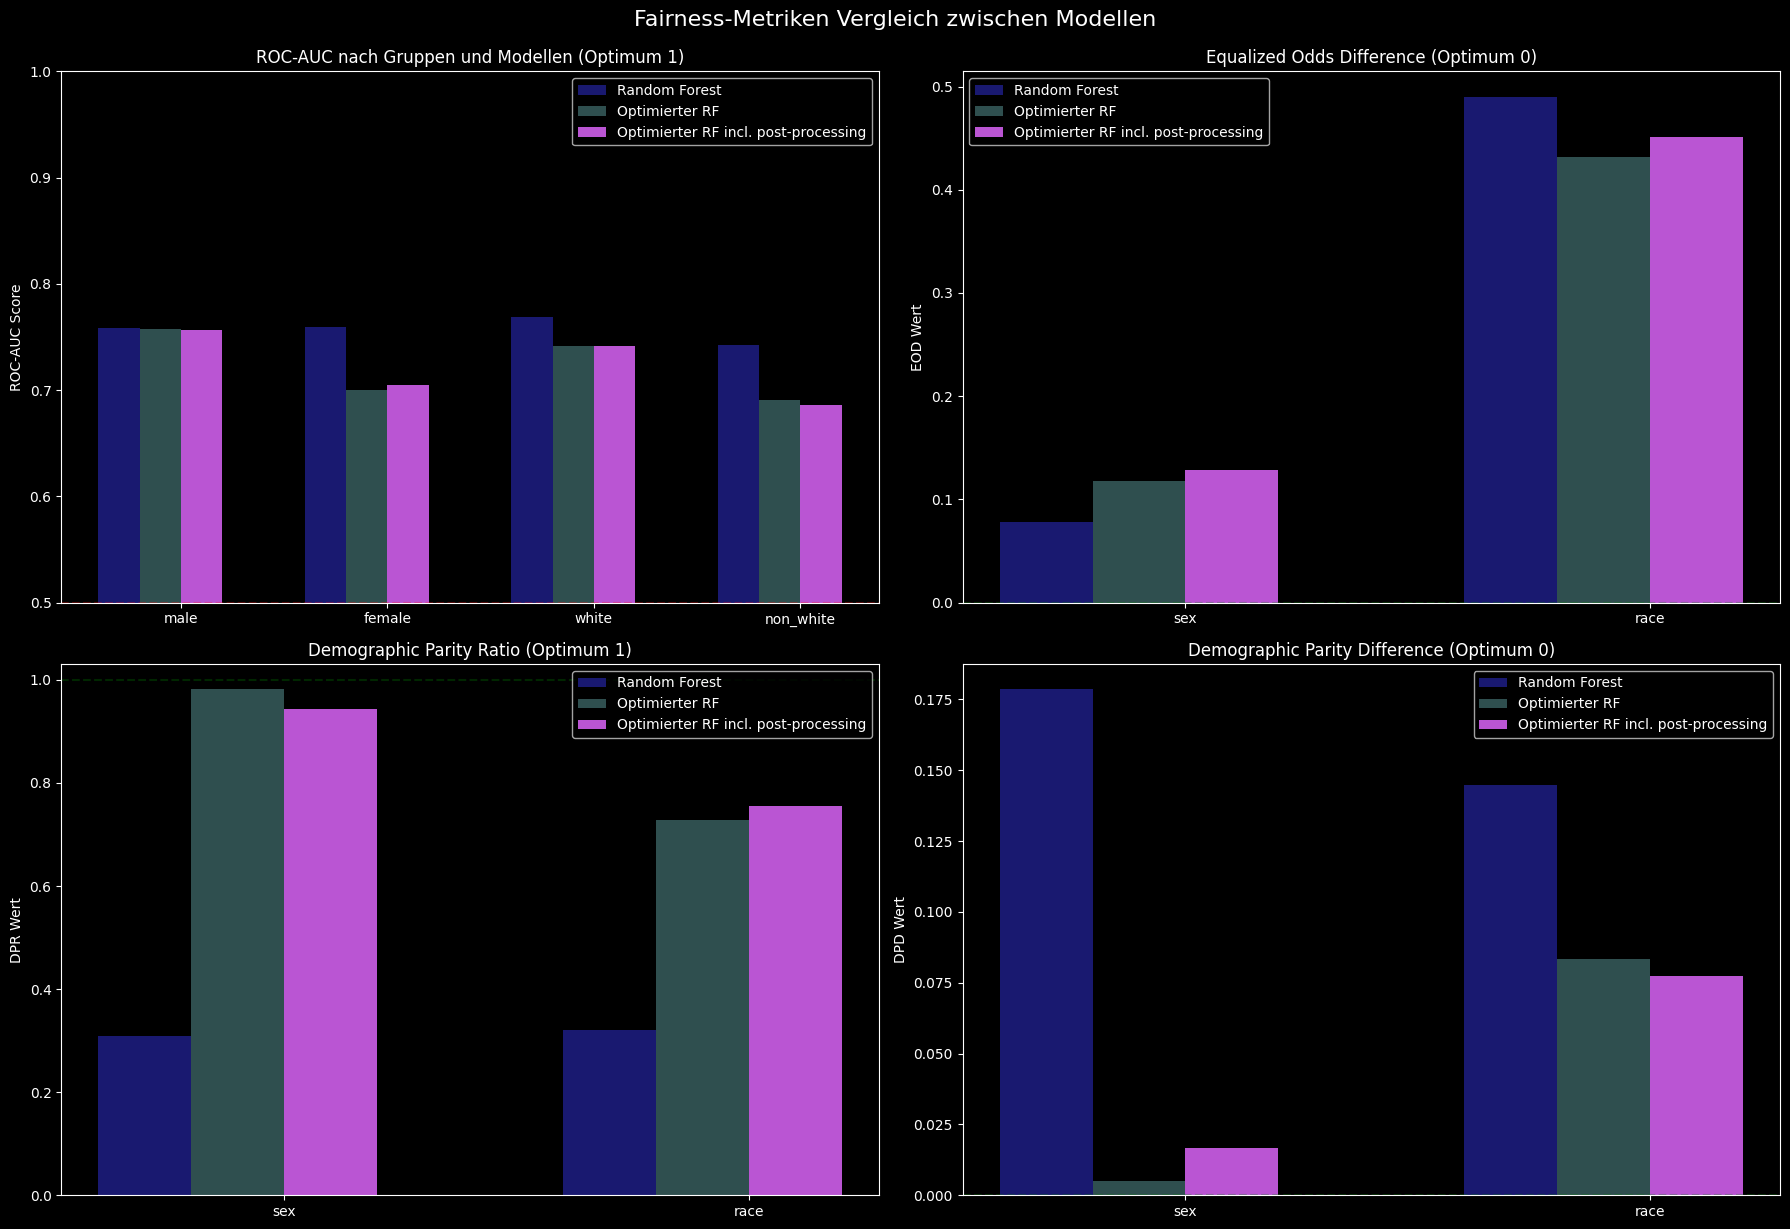

In [31]:
# Dictionary mit allen Modellen erstellen
models = {
#    'Logistic Regression': fair_metric_log,
#    'Decision Tree': fair_metric_dt,
    'Random Forest': fair_metric_rf,
#    'Baysian RF': fair_metric_rf_ba,
    'Optimierter RF': fair_metric_rf_fc,
    "Optimierter RF incl. post-processing": fair_metric_rf_fc_post 
}

# Figure mit 2x2 Subplots erstellen
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Farbpalette für die Modelle
colors = [
#    "silver", 
#          "teal", 
          "midnightblue", 
#          "rebeccapurple", 
          "darkslategray", 
          "mediumorchid"]

# 1. ROC-AUC Vergleich (oben links)
ax = axes[0, 0]
roc_metrics = ["male", "female", "white", "non_white"]
x = np.arange(len(roc_metrics))
width = 0.2 

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["roc_auc"][metric] for metric in roc_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('ROC-AUC Score')
ax.set_title('ROC-AUC nach Gruppen und Modellen (Optimum 1)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(roc_metrics)
ax.set_ylim(0.5, 1.0)
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
ax.legend()

# 2. Equalized Odds Difference (oben rechts)
ax = axes[0, 1]
eod_metrics = ["sex", "race"]
x = np.arange(len(eod_metrics))

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["eod"][metric] for metric in eod_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('EOD Wert')
ax.set_title('Equalized Odds Difference (Optimum 0)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(eod_metrics)
ax.axhline(y=0, color='g', linestyle='--', alpha=0.3)
ax.legend()

# 3. Demographic Parity Ratio (unten links)
ax = axes[1, 0]
dpr_metrics = ["sex", "race"]
x = np.arange(len(dpr_metrics))

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["dpr"][metric] for metric in dpr_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('DPR Wert')
ax.set_title('Demographic Parity Ratio (Optimum 1)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(dpr_metrics)
ax.axhline(y=1, color='g', linestyle='--', alpha=0.3)
ax.legend()

# 4. Demographic Parity Difference (unten rechts)
ax = axes[1, 1]
dpd_metrics = ["sex", "race"]
x = np.arange(len(dpd_metrics))

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["dpd"][metric] for metric in dpd_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('DPD Wert')
ax.set_title('Demographic Parity Difference (Optimum 0)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(dpd_metrics)
ax.axhline(y=0, color='g', linestyle='--', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.suptitle('Fairness-Metriken Vergleich zwischen Modellen', fontsize=16, y=1.02)
plt.savefig(r'files\fairness_model_comparison_opt.png', dpi=300, bbox_inches='tight')
plt.show()

##### DPR wieder als eigenständige Visualisierung

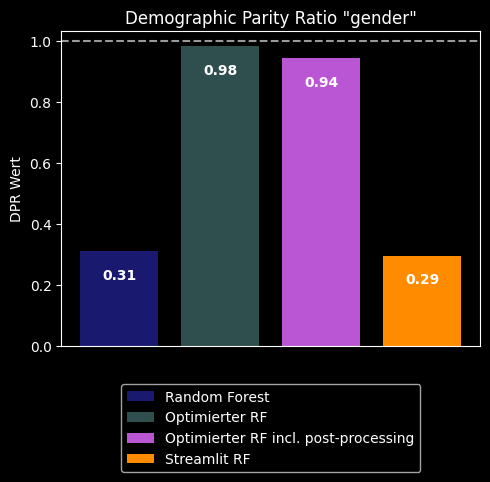

In [77]:
# Dictionary mit allen Modellen erstellen
fair_metric_st = {
    "dpr": {
        "sex": 0.2946546838790220}
}
models = {
#    'Logistic Regression': fair_metric_log,
#    'Decision Tree': fair_metric_dt,
    'Random Forest': fair_metric_rf,
#    'Baysian RF': fair_metric_rf_ba,
    'Optimierter RF': fair_metric_rf_fc,
    "Optimierter RF incl. post-processing": fair_metric_rf_fc_post,
    "Streamlit RF": fair_metric_st
}


# Figure mit 2x2 Subplots erstellen
fig, ax = plt.subplots( figsize=(5, 5))

# Farbpalette für die Modelle
colors = ["midnightblue", "darkslategray","mediumorchid", "darkorange"]

# Demographic Parity Ratio 
dpr_metrics = ["sex"]
x = np.arange(len(dpr_metrics))
width = 0.2
for i, (model_name, fairness_metrics) in enumerate(models.items()):
    value = fairness_metrics["dpr"]["sex"]
    ax.bar(x + i * width * 1.3, value, width, label=model_name, color=colors[i])

    ax.text(
        x=i * width * 1.3,  # X-Position (auf die Balken zentrieren)
        y=value - 0.1,  # Y-Position (leicht über dem Balken)
        s=f"{value:.2f}",  # Zahlenwert mit 2 Dezimalstellen
        ha='center',  # Zentriert ausrichten
        va='bottom',  # Am unteren Rand des Textes ausrichten
        fontsize=10,  # Schriftgröße anpassen
        color="white",  # Kontrast anpassen
        fontweight="bold"
    )
    
ax.set_ylabel('DPR Wert')
ax.set_title('Demographic Parity Ratio "gender"')
ax.set_xticks([])
ax.axhline(y=1, color='silver', linestyle='--', alpha=0.8)
ax.legend(loc="upper center",bbox_to_anchor=(0.5, -0.1), fontsize=10)




plt.tight_layout()
#plt.suptitle('Fairness-Metriken Vergleich zwischen Modellen', fontsize=16, y=1.02)
plt.savefig(r'files\fairness_model_comparison_opt_DPR.svg', dpi=300, bbox_inches='tight')
plt.show()

##### F1-Score aller Modelle

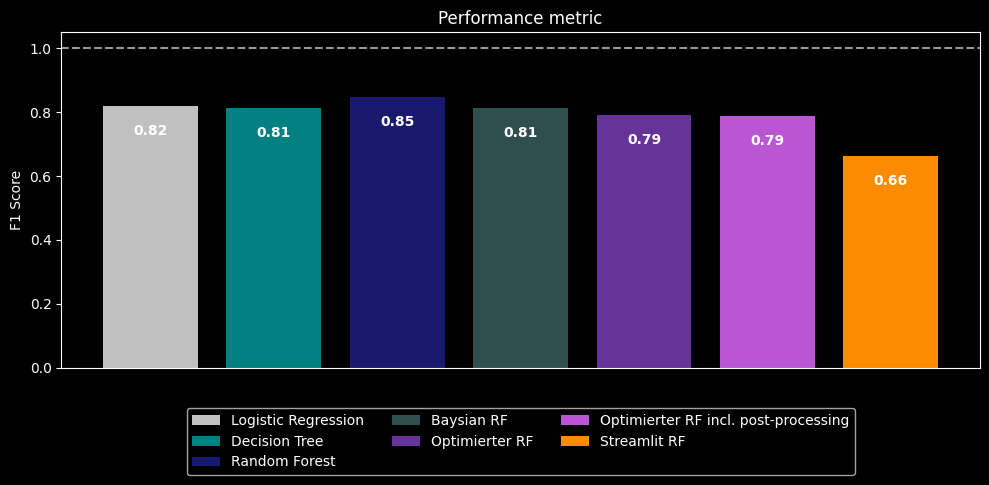

In [97]:
# Ergebnisse der drei Basismodelle
metrics_st = {"F1 Score": 0.6622002820874471}
model_results = {
    "Logistic Regression": metrics_log,
    "Decision Tree": metrics_dt,
    "Random Forest": metrics_rf,
    "Baysian RF": metrics_rf_ba,
    'Optimierter RF': metrics_rf_opt,
    "Optimierter RF incl. post-processing": metrics_rf_opt_post,
    "Streamlit RF": metrics_st
}


fig, ax = plt.subplots( figsize=(10, 5))

# Farbpalette für die Modelle
colors = ["silver", "teal","midnightblue","darkslategray","rebeccapurple","mediumorchid", "darkorange"]

# PErformance metric
metric = ["F1 Score"]
x = np.arange(len(metric))
width = 0.2
for i, (model_name, metrics) in enumerate(model_results.items()):
    value = metrics["F1 Score"]
    ax.bar(x + i * width * 1.3, value, width, label=model_name, color=colors[i])

    ax.text(
        x=i * width * 1.3,  # X-Position (auf die Balken zentrieren)
        y=value - 0.1,  # Y-Position (leicht über dem Balken)
        s=f"{value:.2f}",  # Zahlenwert mit 2 Dezimalstellen
        ha='center',  # Zentriert ausrichten
        va='bottom',  # Am unteren Rand des Textes ausrichten
        fontsize=10,  # Schriftgröße anpassen
        color="white",  # Kontrast anpassen
        fontweight="bold"
    )
    
ax.set_ylabel('F1 Score')
ax.set_title('Performance metric')
ax.set_xticks([])
ax.axhline(y=1, color='silver', linestyle='--', alpha=0.8)
ax.legend(loc="upper center",bbox_to_anchor=(0.5, -0.1), fontsize=10, ncol=3)




plt.tight_layout()
#plt.suptitle('Fairness-Metriken Vergleich zwischen Modellen', fontsize=16, y=1.02)
plt.savefig(r'files\model_comparison_F1.svg', dpi=300, bbox_inches='tight')
plt.show()


##### DPR aller Modelle

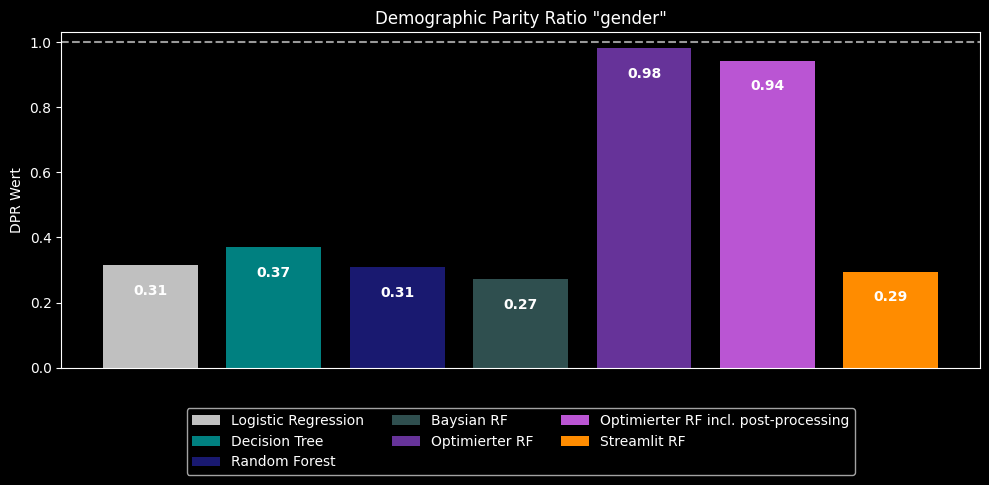

In [94]:
# Dictionary mit allen Modellen erstellen
fair_metric_st = {
    "dpr": {
        "sex": 0.2946546838790220}
}
models = {
    'Logistic Regression': fair_metric_log,
    'Decision Tree': fair_metric_dt,
    'Random Forest': fair_metric_rf,
    'Baysian RF': fair_metric_rf_ba,
    'Optimierter RF': fair_metric_rf_fc,
    "Optimierter RF incl. post-processing": fair_metric_rf_fc_post,
    "Streamlit RF": fair_metric_st
}


# Figure mit 2x2 Subplots erstellen
fig, ax = plt.subplots( figsize=(10, 5))

# Farbpalette für die Modelle
colors = ["silver", "teal","midnightblue","darkslategray","rebeccapurple","mediumorchid", "darkorange"]


# Demographic Parity Ratio 
dpr_metrics = ["sex"]
x = np.arange(len(dpr_metrics))
width = 0.2
for i, (model_name, fairness_metrics) in enumerate(models.items()):
    value = fairness_metrics["dpr"]["sex"]
    ax.bar(x + i * width * 1.3, value, width, label=model_name, color=colors[i])

    ax.text(
        x=i * width * 1.3,  # X-Position (auf die Balken zentrieren)
        y=value - 0.1,  # Y-Position (leicht über dem Balken)
        s=f"{value:.2f}",  # Zahlenwert mit 2 Dezimalstellen
        ha='center',  # Zentriert ausrichten
        va='bottom',  # Am unteren Rand des Textes ausrichten
        fontsize=10,  # Schriftgröße anpassen
        color="white",  # Kontrast anpassen
        fontweight="bold"
    )
    
ax.set_ylabel('DPR Wert')
ax.set_title('Demographic Parity Ratio "gender"')
ax.set_xticks([])
ax.axhline(y=1, color='silver', linestyle='--', alpha=0.8)
ax.legend(loc="upper center",bbox_to_anchor=(0.5, -0.1), fontsize=10, ncol=3)




plt.tight_layout()
#plt.suptitle('Fairness-Metriken Vergleich zwischen Modellen', fontsize=16, y=1.02)
plt.savefig(r'files\fairness_model_comparison_opt_DPR.svg', dpi=300, bbox_inches='tight')
plt.show()

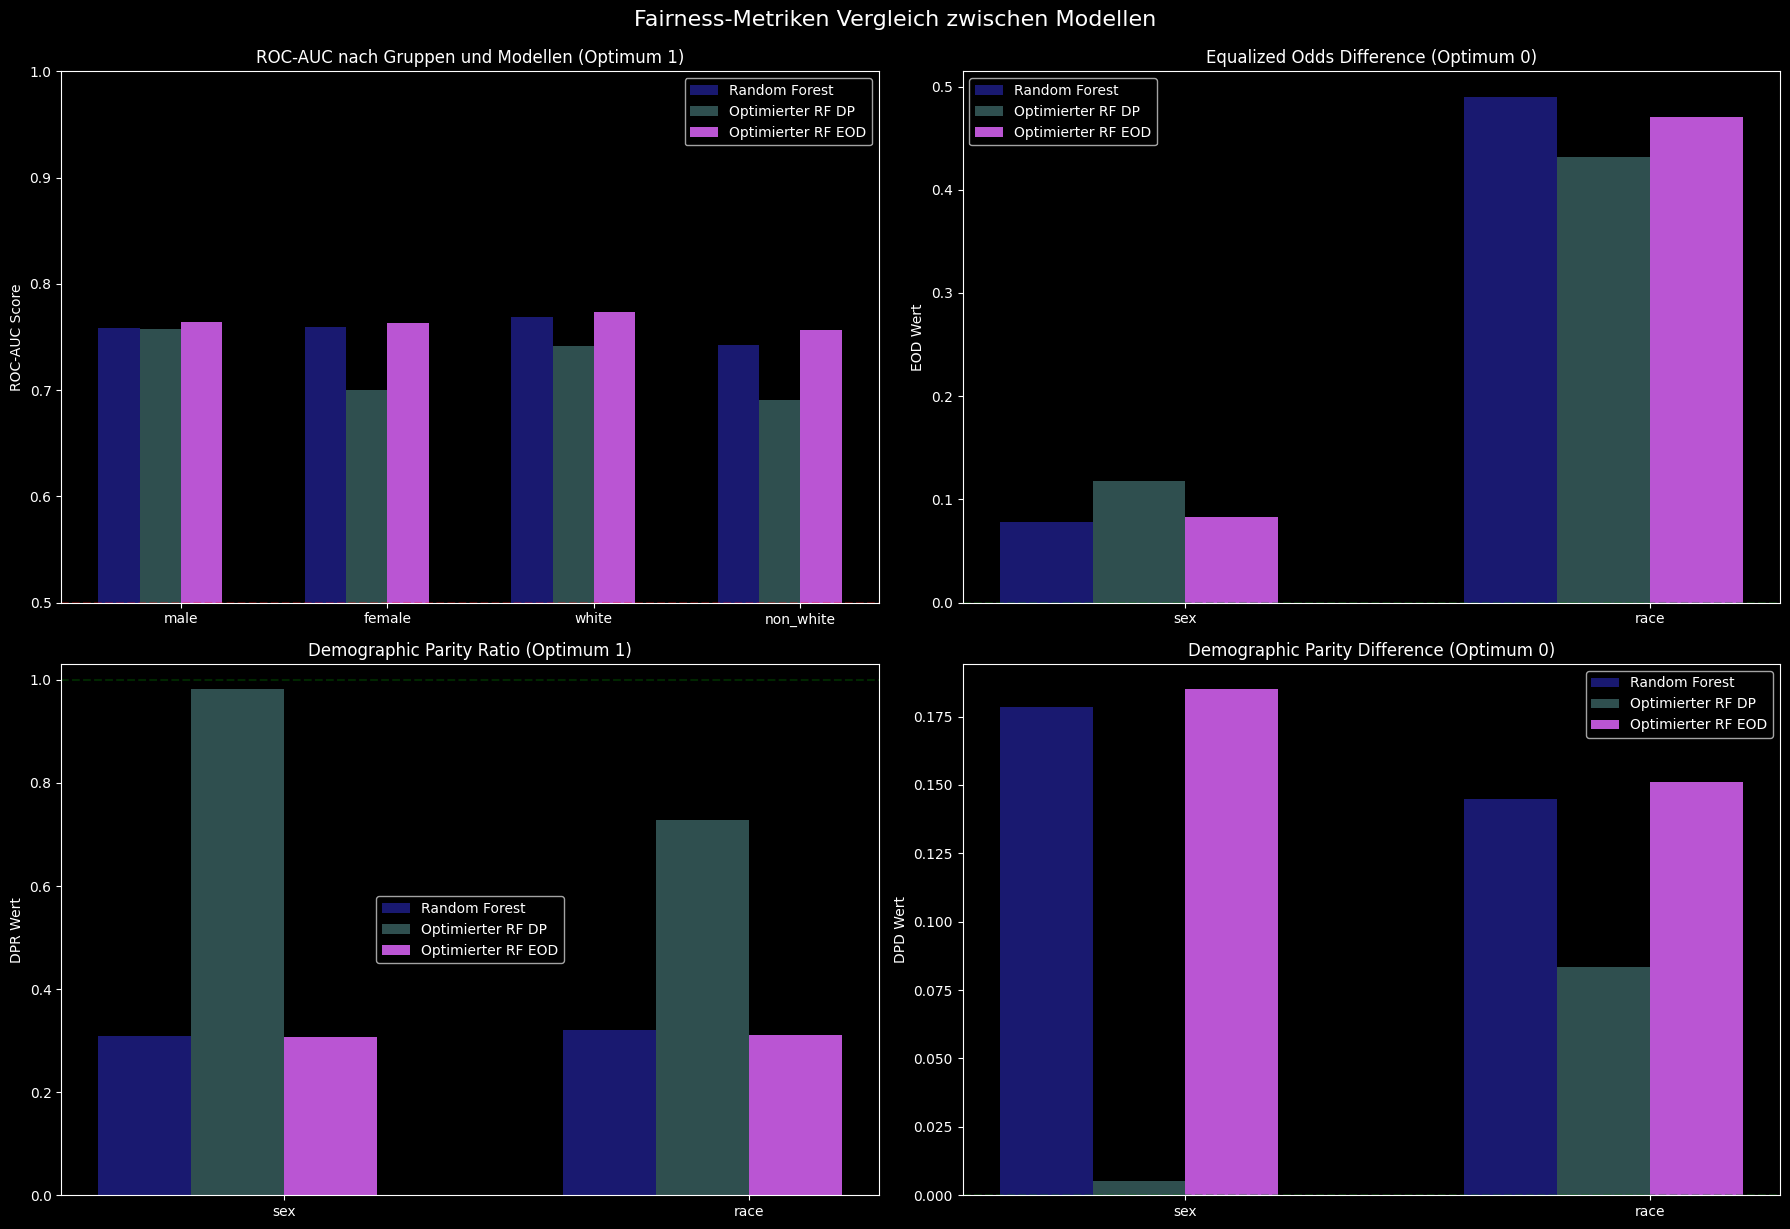

In [34]:
# Dictionary mit allen Modellen erstellen
models = {
#    'Logistic Regression': fair_metric_log,
#    'Decision Tree': fair_metric_dt,
    'Random Forest': fair_metric_rf,
#    'Baysian RF': fair_metric_rf_ba,
    'Optimierter RF DP': fair_metric_rf_fc,
    "Optimierter RF EOD": fair_eod_metric_rf_fc
}

# Figure mit 2x2 Subplots erstellen
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Farbpalette für die Modelle
colors = [
#    "silver", 
#          "teal", 
          "midnightblue", 
#          "rebeccapurple", 
          "darkslategray", 
          "mediumorchid"]

# 1. ROC-AUC Vergleich (oben links)
ax = axes[0, 0]
roc_metrics = ["male", "female", "white", "non_white"]
x = np.arange(len(roc_metrics))
width = 0.2 

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["roc_auc"][metric] for metric in roc_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('ROC-AUC Score')
ax.set_title('ROC-AUC nach Gruppen und Modellen (Optimum 1)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(roc_metrics)
ax.set_ylim(0.5, 1.0)
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
ax.legend()

# 2. Equalized Odds Difference (oben rechts)
ax = axes[0, 1]
eod_metrics = ["sex", "race"]
x = np.arange(len(eod_metrics))

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["eod"][metric] for metric in eod_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('EOD Wert')
ax.set_title('Equalized Odds Difference (Optimum 0)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(eod_metrics)
ax.axhline(y=0, color='g', linestyle='--', alpha=0.3)
ax.legend()

# 3. Demographic Parity Ratio (unten links)
ax = axes[1, 0]
dpr_metrics = ["sex", "race"]
x = np.arange(len(dpr_metrics))

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["dpr"][metric] for metric in dpr_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('DPR Wert')
ax.set_title('Demographic Parity Ratio (Optimum 1)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(dpr_metrics)
ax.axhline(y=1, color='g', linestyle='--', alpha=0.3)
ax.legend()

# 4. Demographic Parity Difference (unten rechts)
ax = axes[1, 1]
dpd_metrics = ["sex", "race"]
x = np.arange(len(dpd_metrics))

for i, (model_name, fairness_metrics) in enumerate(models.items()):
    values = [fairness_metrics["dpd"][metric] for metric in dpd_metrics]
    ax.bar(x + i*width, values, width, label=model_name, color=colors[i])

ax.set_ylabel('DPD Wert')
ax.set_title('Demographic Parity Difference (Optimum 0)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(dpd_metrics)
ax.axhline(y=0, color='g', linestyle='--', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.suptitle('Fairness-Metriken Vergleich zwischen Modellen', fontsize=16, y=1.02)
plt.savefig(r'files\fairness_model_comparison_opt_2.svg', dpi=100, bbox_inches='tight')
plt.show()

#### Bewertung
Der optimierte Random Forest zeigt deutliche Verbesserungen in den Fairness-Metriken
Aber: hat Einbuße bei den ROC-AUC-Werten

Extreme Verbesserung bei DPR und DPD. wurde aber auch dahingehend optimiert

ToDos
- Trade-off zwischen Fairness und Performance: Wie stark werden die ROC-AUC-Werte durch die Fairness-Optimierung beeinträchtigt. Bei dem optimierten RF sind leichte Einbußen bei der Performance zu erkennen.

- Unterschiede zwischen Fairness-Metriken: Die Optimierung verbessert DPR (sex), aber EOD weniger stark. Eventuell 2. Analyse nach EOD ausgerichtet

- Post-Processing vs. In-Training-Optimierung: Vergleich, wie sich das Post-Processing auf die einzelnen Fairness-Metriken im Vergleich zur reinen ExponentiatedGradient-Optimierung auswirkt.

- Weiteres Feature-Engineering
- Random-Forest Baysian auch auf andere scorings ansetzen und danach In-Training-Optimierung und Post-Processing anwenden

- Theoretisch: Verallgemeinerbarkeit, lässt sich das auf andere Datensetze ebenso projizieren


- LangChain